In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astromodal.config import load_config
from tqdm import tqdm
import polars as pl
import random
from pathlib import Path
from astromodal.datasets.datacubes import load_datacube_files

In [110]:
config = load_config("/home/schwarz/projetoFM/config.yaml")

hdd_folder = config['hdd_folder']

hddfolder = Path(config["hdd_folder"]) / "image_latents" 

In [4]:
file = config['datacubes_paths'].replace('*', 'STRIPE82-0002')

import polars as pl

header = pl.read_parquet(file, n_rows=0)
columns = [col for col in header.columns if 'desi' in col] + ["id", "mag_psf_r"]

In [5]:
train_files, val_files = load_datacube_files(config['datacubes_paths'], train_val_split=0.9, nfiles_subsample=800)

[info] - Found 2444 datacube files
[info] - Subsampled to 800 files
[info] - Training files: 720
[info] - Validation files: 80


In [6]:
train_df = None

for f in tqdm(train_files, desc="Loading train files"):
    try:
        df = pl.read_parquet(f, columns=columns, use_pyarrow=True)
        df = df.filter(pl.col(columns[0]).is_not_null())
        
        df = df.filter(pl.col("mag_psf_r") < 21)
        
        
        if df.height == 0:
            continue

        train_df = df if train_df is None else pl.concat([train_df, df], how="vertical", rechunk=False)
    except Exception as e:
        pass


Loading train files:   0%|          | 0/720 [00:00<?, ?it/s]

Loading train files: 100%|██████████| 720/720 [04:26<00:00,  2.70it/s]


In [53]:
val_df = None

for f in tqdm(val_files, desc="Loading val files"):
    try:
        df = pl.read_parquet(f, columns=columns, use_pyarrow=True)
        df = df.filter(pl.col(columns[0]).is_not_null())
        
        df = df.filter(pl.col("mag_psf_r") < 21)
        
        if df.height == 0:
            continue

        val_df = df if val_df is None else pl.concat([val_df, df], how="vertical", rechunk=False)
    except Exception as e:
        pass

Loading val files: 100%|██████████| 80/80 [01:34<00:00,  1.19s/it]


In [12]:
train_df = train_df.filter(pl.col("desi_TARGET_RA").is_not_null())

In [13]:
train_df

gaia_designation,desi_TARGETID,desi_PETAL_LOC,desi_DEVICE_LOC,desi_LOCATION,desi_FIBER,desi_COADD_FIBERSTATUS,desi_TARGET_RA,desi_TARGET_DEC,desi_PMRA,desi_PMDEC,desi_REF_EPOCH,desi_LAMBDA_REF,desi_FA_TARGET,desi_FA_TYPE,desi_OBJTYPE,desi_FIBERASSIGN_X,desi_FIBERASSIGN_Y,desi_PRIORITY,desi_SUBPRIORITY,desi_OBSCONDITIONS,desi_RELEASE,desi_BRICKNAME,desi_BRICKID,desi_BRICK_OBJID,desi_MORPHTYPE,desi_EBV,desi_FLUX_G,desi_FLUX_R,desi_FLUX_Z,desi_FLUX_W1,desi_FLUX_W2,desi_FLUX_IVAR_G,desi_FLUX_IVAR_R,desi_FLUX_IVAR_Z,desi_FLUX_IVAR_W1,desi_FLUX_IVAR_W2,…,desi_PHOTSYS,desi_PRIORITY_INIT,desi_NUMOBS_INIT,desi_DESI_TARGET,desi_BGS_TARGET,desi_MWS_TARGET,desi_SCND_TARGET,desi_PLATE_RA,desi_PLATE_DEC,desi_TILEID,desi_COADD_NUMEXP,desi_COADD_EXPTIME,desi_COADD_NUMNIGHT,desi_COADD_NUMTILE,desi_MEAN_DELTA_X,desi_RMS_DELTA_X,desi_MEAN_DELTA_Y,desi_RMS_DELTA_Y,desi_MEAN_FIBER_RA,desi_STD_FIBER_RA,desi_MEAN_FIBER_DEC,desi_STD_FIBER_DEC,desi_MEAN_PSF_TO_FIBER_SPECFLUX,desi_MEAN_FIBER_X,desi_MEAN_FIBER_Y,desi_desi_file,desi_wave_b,desi_flux_b,desi_ivar_b,desi_wave_r,desi_flux_r,desi_ivar_r,desi_wave_z,desi_flux_z,desi_ivar_z,id,mag_psf_r
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],binary,f64
"""Gaia DR3 3830821862632469120""",3.9628e16,5.0,138.0,5138.0,2951.0,0.0,154.162968,-0.710913,0.0,0.0,2015.5,5400.0,4.6117e18,1.0,"""TGT""",46.589912,220.020248,3400.0,0.921481,63.0,9010.0,"""1541m007""",326664.0,3084.0,"""PSF""",0.047524,5.058965,4.832013,7.208213,9.45708,9.465352,950.477173,449.357727,115.363297,3.007306,0.61708,…,"""S""",3400.0,4.0,4.6117e18,0.0,0.0,1.0066432e8,154.162968,-0.710913,8780.0,1.0,848.851685,1.0,1.0,-0.005,0.005,0.002,0.002,154.162947,0.0,-0.710921,0.0,0.789,46.573002,219.951004,"""/home/astrodados4/downloads/de…","[3600.0, 3600.800049, … 5800.0]","[5.842655, 11.877431, … 1.448516]","[0.102352, 0.112176, … 2.377451]","[5760.0, 5760.799805, … 7620.0]","[2.944133, 2.356992, … 1.810561]","[2.676691, 2.010597, … 0.372863]","[7520.0, 7520.799805, … 9824.0]","[0.483411, 0.067808, … 1.31143]","[16.207237, 12.59141, … 15.660495]","b""i06n01s040003U""",20.496198
"""Gaia DR3 3830810970595406208""",3.9628e16,6.0,71.0,6071.0,3229.0,0.0,154.327413,-0.710012,8.777453,-7.695374,2020.962402,5400.0,2.3058e18,1.0,"""TGT""",-55.855259,162.830856,1100.0,0.960973,7.0,9010.0,"""1543m007""",326665.0,1881.0,"""PSF""",0.048965,42.235561,142.827332,329.055695,195.804306,104.315681,234.24115,56.686199,29.353958,1.240451,0.470704,…,"""S""",1100.0,1.0,0.0,0.0,0.0,null,154.327413,-0.710012,80614.0,3.0,900.0,1.0,1.0,0.001667,0.003317,0.005667,0.006245,154.327406,0.042074,-0.709989,0.038086,0.789,-55.856335,162.776337,"""/home/astrodados4/downloads/de…","[3600.0, 3600.800049, … 5800.0]","[12.681102, 11.179079, … 34.434139]","[0.018049, 0.01711, … 0.469362]","[5760.0, 5760.799805, … 7620.0]","[45.556183, 35.034519, … 47.71125]","[0.020589, 0.016669, … 0.22884]","[7520.0, 7520.799805, … 9824.0]","[53.827881, 46.496712, … 42.090805]","[0.124965, 0.121411, … 0.613693]","b""i06n01s040005K""",17.296911
"""Gaia DR3 3830775683144446720""",3.9628e16,0.0,0.0,0.0,400.0,0.0,155.051274,-0.707967,0.664293,-12.956626,2015.5,5400.0,2.3058e18,1.0,"""TGT""",-3.943787,-22.842409,1500.0,0.686674,516.0,9010.0,"""1551m007""",326668.0,1143.0,"""PSF""",0.048281,24.307194,38.925076,46.03862,13.66955,1.975154,414.735474,178.71167,101.007759,2.832975,0.663923,…,"""S""",1500.0,2.0,2.3058e18,0.0,1280.0,0.0,155.051274,-0.707967,23114.0,1.0,682.696106,1.0,1.0,-0.000199,0.000199,0.000956,0.000956,155.051273,0.0,-0.70797,0.0,0.789,-3.942801,-22.827955,"""/home/astrodados4/downloads/de…","[3600.0, 3600.800049, … 5800.0]","[16.957273, -6.945667, … 11.163612]","[0.012221, 0.012745, … 0.262285]","[57

In [45]:
from astromodal.datasets.desi_spectra import DesiStitchedSpectraDataset, desi_collate_pad_flux

from torch.utils.data import DataLoader

In [46]:
dataset = DesiStitchedSpectraDataset(df)
loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    collate_fn=desi_collate_pad_flux,
)
    #
  

In [47]:
from astromodal.models.spectral_autoencoder import SpectraAutoEncoder

In [49]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SpectraAutoEncoder(latent_dim=16, base_channels=64, num_down=4).to(device)


In [50]:
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SpectraAutoEncoder(in_channels=2, latent_dim=16, base_channels=64, num_down=4).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for epoch in range(10):
    tr = model.train_epoch(loader, opt, device)
    print(f"epoch={epoch} train_loss={tr:.6f}")


Training:   0%|          | 0/76 [00:00<?, ?it/s]

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/schwarz/miniconda3/lib/python3.13/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/schwarz/miniconda3/lib/python3.13/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ~~~~~~~~~~~~~~~^^^^^^
  File "<string>", line 16, in desi_collate_pad_flux
AttributeError: 'tuple' object has no attribute 'flux'


In [97]:
# ============================================================
# Flux-only Spectra AutoEncoder (uses ivar ONLY for training)
# - Input/Output: flux only  [B, L, 1]
# - Dataset returns: x_flux_norm [L,1], mask [L], w [L] (weights derived from ivar)
# - Loss: weighted MSE over valid pixels using w (ivar-scaled for normalization)
# - Optional: returns per-sample (mu, sigma) so you can denormalize reconstructions
# ============================================================

from __future__ import annotations

from dataclasses import dataclass
from typing import Optional, Tuple, List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

import logpool


# -------------------------
# Normalization helpers
# -------------------------

@dataclass
class NormStats:
    mu: float
    sigma: float

def robust_flux_stats(flux: np.ndarray, mask: np.ndarray, eps: float = 1e-6) -> NormStats:
    """
    Robust per-spectrum stats using median + MAD.
    flux: [L]
    mask: [L] bool (True valid pixel)
    """
    v = flux[mask] if mask is not None else flux
    v = v[np.isfinite(v)]
    if v.size == 0:
        return NormStats(mu=0.0, sigma=1.0)

    mu = float(np.median(v))
    mad = float(np.median(np.abs(v - mu)))
    sigma = 1.4826 * mad  # MAD -> ~sigma for normal
    if not np.isfinite(sigma) or sigma < eps:
        # fallback to std
        sigma2 = float(np.std(v))
        sigma = sigma2 if (np.isfinite(sigma2) and sigma2 >= eps) else 1.0

    return NormStats(mu=mu, sigma=sigma)

def normalize_flux(flux: np.ndarray, stats: NormStats) -> np.ndarray:
    return (flux - stats.mu) / (stats.sigma + 1e-12)

def denormalize_flux(flux_norm: np.ndarray, stats: NormStats) -> np.ndarray:
    return flux_norm * stats.sigma + stats.mu

def ivar_to_weights_for_normalized_flux(
    ivar: np.ndarray,
    stats: NormStats,
    mask: np.ndarray,
    *,
    use_sqrt: bool = True,
    w_clip_quantile: float = 0.995,
    eps: float = 1e-12
) -> np.ndarray:
    """
    If f' = (f - mu)/sigma, then ivar' = ivar * sigma^2.

    We then optionally use sqrt(ivar') to reduce domination by very high ivar,
    and clip weights at a high quantile among valid pixels.
    """
    if ivar.size == 0:
        return np.zeros_like(ivar, dtype=np.float32)

    iv = np.asarray(ivar, dtype=np.float64)
    m = np.asarray(mask, dtype=bool)

    # scale to match normalized flux units
    iv_scaled = iv * (stats.sigma ** 2)

    # valid weights: finite and >0 and valid pixel
    w = np.zeros_like(iv_scaled, dtype=np.float64)
    good = m & np.isfinite(iv_scaled) & (iv_scaled > 0)
    if np.any(good):
        w_good = iv_scaled[good]

        if use_sqrt:
            w_good = np.sqrt(w_good)

        # clip extreme weights (optional but recommended)
        if 0.0 < w_clip_quantile < 1.0:
            cap = np.quantile(w_good, w_clip_quantile)
            if np.isfinite(cap) and cap > eps:
                w_good = np.minimum(w_good, cap)

        w[good] = w_good

    return w.astype(np.float32)


# -------------------------
# Stitching (your code, unchanged)
# -------------------------

def _as_1d_float(x) -> np.ndarray:
    if x is None:
        return np.empty(0, dtype=np.float64)
    a = np.asarray(x, dtype=np.float64)
    if a.ndim == 0:
        if np.isfinite(a.item()):
            return a.reshape(1)
        return np.empty(0, dtype=np.float64)
    return np.ravel(a)

def _trim_to_min_len(w, f, iv):
    n = min(w.size, f.size, iv.size)
    if n == 0:
        return (np.empty(0, dtype=np.float64),
                np.empty(0, dtype=np.float64),
                np.empty(0, dtype=np.float64))
    return (w[:n], f[:n], iv[:n])

def stitch_desi_arms(
    wave_b, flux_b, ivar_b,
    wave_r, flux_r, ivar_r,
    wave_z, flux_z, ivar_z,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns: wave, flux, ivar, mask
      mask True means valid pixel (ivar > 0 and finite) after stitching/combining.
    """

    wb = _as_1d_float(wave_b); fb = _as_1d_float(flux_b); ivb = _as_1d_float(ivar_b)
    wb, fb, ivb = _trim_to_min_len(wb, fb, ivb)

    wr = _as_1d_float(wave_r); fr = _as_1d_float(flux_r); ivr = _as_1d_float(ivar_r)
    wr, fr, ivr = _trim_to_min_len(wr, fr, ivr)

    wz = _as_1d_float(wave_z); fz = _as_1d_float(flux_z); ivz = _as_1d_float(ivar_z)
    wz, fz, ivz = _trim_to_min_len(wz, fz, ivz)

    w = np.concatenate([wb, wr, wz]) if (wb.size + wr.size + wz.size) > 0 else np.empty(0, dtype=np.float64)
    f = np.concatenate([fb, fr, fz]) if (fb.size + fr.size + fz.size) > 0 else np.empty(0, dtype=np.float64)
    iv = np.concatenate([ivb, ivr, ivz]) if (ivb.size + ivr.size + ivz.size) > 0 else np.empty(0, dtype=np.float64)

    if w.size == 0:
        return w, f, iv, np.empty(0, dtype=bool)

    m = np.isfinite(w) & np.isfinite(f) & np.isfinite(iv) & (iv >= 0)
    w, f, iv = w[m], f[m], iv[m]
    if w.size == 0:
        return w, f, iv, np.empty(0, dtype=bool)

    order = np.argsort(w)
    w, f, iv = w[order], f[order], iv[order]

    w_unique, inv, counts = np.unique(w, return_inverse=True, return_counts=True)

    if np.any(counts > 1):
        num = np.zeros_like(w_unique, dtype=np.float64)
        den = np.zeros_like(w_unique, dtype=np.float64)
        np.add.at(num, inv, iv * f)
        np.add.at(den, inv, iv)

        flux_out = np.zeros_like(w_unique, dtype=np.float64)
        mask_out = den > 0
        flux_out[mask_out] = num[mask_out] / den[mask_out]

        bad = ~mask_out
        if np.any(bad):
            sum_f = np.zeros_like(w_unique, dtype=np.float64)
            np.add.at(sum_f, inv, f)
            flux_out[bad] = sum_f[bad] / counts[bad]

        ivar_out = den
        return w_unique, flux_out, ivar_out, mask_out

    mask = iv > 0
    return w, f, iv, mask


# -------------------------
# Dataset: returns flux only + mask + weights (from ivar)
# -------------------------

class DesiStitchedFluxOnlyDataset(torch.utils.data.Dataset):
    """
    Returns:
      x    : float32 [L, 1]  (normalized flux)
      mask : bool    [L]     (valid pixel)
      w    : float32 [L]     (loss weights; derived from ivar; zero for invalid)
      stats: float32 [2]     (mu, sigma) optional, useful for denorm/debug
    """

    def __init__(
        self,
        df,
        *,
        return_stats: bool = True,
        use_sqrt_weights: bool = True,
        w_clip_quantile: float = 0.995,
    ):
        self.df = df
        self.return_stats = return_stats
        self.use_sqrt_weights = use_sqrt_weights
        self.w_clip_quantile = w_clip_quantile

    def __len__(self):
        return self.df.height

    def __getitem__(self, idx):
        row = self.df.row(idx, named=True)

        wv, f, iv, m = stitch_desi_arms(
            row.get("desi_wave_b"), row.get("desi_flux_b"), row.get("desi_ivar_b"),
            row.get("desi_wave_r"), row.get("desi_flux_r"), row.get("desi_ivar_r"),
            row.get("desi_wave_z"), row.get("desi_flux_z"), row.get("desi_ivar_z"),
        )

        # If empty: return dummy length-1, fully invalid
        if f.size == 0:
            x = np.zeros((1, 1), dtype=np.float32)
            mask = np.zeros((1,), dtype=np.bool_)
            w = np.zeros((1,), dtype=np.float32)
            if self.return_stats:
                stats = np.array([0.0, 1.0], dtype=np.float32)
                return torch.from_numpy(x), torch.from_numpy(mask), torch.from_numpy(w), torch.from_numpy(stats)
            return torch.from_numpy(x), torch.from_numpy(mask), torch.from_numpy(w)

        mask = m.astype(bool)

        # robust per-spectrum normalization on VALID pixels
        stats = robust_flux_stats(f, mask)
        f_norm = normalize_flux(f, stats).astype(np.float32)

        # weights from ivar scaled into normalized units
        w_loss = ivar_to_weights_for_normalized_flux(
            iv,
            stats,
            mask,
            use_sqrt=self.use_sqrt_weights,
            w_clip_quantile=self.w_clip_quantile,
        )  # [L] float32, already zeroed where invalid

        x = f_norm[:, None]  # [L,1]
        if self.return_stats:
            stats_arr = np.array([stats.mu, stats.sigma], dtype=np.float32)
            return (torch.from_numpy(x),
                    torch.from_numpy(mask),
                    torch.from_numpy(w_loss),
                    torch.from_numpy(stats_arr))
        return (torch.from_numpy(x),
                torch.from_numpy(mask),
                torch.from_numpy(w_loss))


def desi_collate_pad_flux_only(batch, pad_x: float = 0.0):
    """
    batch entries:
      either (x[L,1], mask[L], w[L]) or (x[L,1], mask[L], w[L], stats[2])

    returns:
      x_pad    : [B, Lmax, 1] float32
      mask_pad : [B, Lmax]    bool
      w_pad    : [B, Lmax]    float32
      lengths  : [B]          int64
      stats    : [B, 2]       float32 (optional)
    """
    has_stats = (len(batch[0]) == 4)

    if has_stats:
        xs, ms, ws, st = zip(*batch)
        stats = torch.stack(st, dim=0).to(torch.float32)  # [B,2]
    else:
        xs, ms, ws = zip(*batch)
        stats = None

    lengths = torch.tensor([x.shape[0] for x in xs], dtype=torch.long)
    Lmax = int(lengths.max().item())
    B = len(xs)

    x_pad = torch.full((B, Lmax, 1), float(pad_x), dtype=torch.float32)
    mask_pad = torch.zeros((B, Lmax), dtype=torch.bool)
    w_pad = torch.zeros((B, Lmax), dtype=torch.float32)

    for i, (x, m, w) in enumerate(zip(xs, ms, ws)):
        L = x.shape[0]
        x_pad[i, :L] = x
        mask_pad[i, :L] = m
        w_pad[i, :L] = w

    if has_stats:
        return x_pad, mask_pad, w_pad, lengths, stats
    return x_pad, mask_pad, w_pad, lengths


# -------------------------
# Model (flux-only)
# -------------------------

def _gn1d(num_channels: int, num_groups: int = 8) -> nn.GroupNorm:
    g = min(num_groups, num_channels)
    while num_channels % g != 0 and g > 1:
        g -= 1
    return nn.GroupNorm(g, num_channels)

class ConvGNAct1D(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, k: int = 5, s: int = 1, p: Optional[int] = None):
        super().__init__()
        if p is None:
            p = k // 2
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=True)
        self.gn = _gn1d(out_ch)
        self.act = nn.SiLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.act(self.gn(self.conv(x)))

class ResBlock1D(nn.Module):
    def __init__(self, channels: int, k: int = 5):
        super().__init__()
        p = k // 2
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=k, padding=p, bias=True)
        self.gn1 = _gn1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=k, padding=p, bias=True)
        self.gn2 = _gn1d(channels)
        self.act = nn.SiLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.act(self.gn1(self.conv1(x)))
        h = self.gn2(self.conv2(h))
        return self.act(h + x)

class SpectraEncoder(nn.Module):
    """
    Expects x in [B, L, 1] and returns z in [B, latent_dim, T].
    """
    def __init__(self, in_channels: int = 1, latent_dim: int = 16, base_channels: int = 64, num_down: int = 4, k: int = 5):
        super().__init__()
        self.proj = nn.Conv1d(in_channels, base_channels, kernel_size=1, bias=True)

        blocks: List[nn.Module] = []
        ch = base_channels
        for i in range(num_down):
            blocks += [
                ResBlock1D(ch, k=k),
                ConvGNAct1D(ch, ch * 2 if i < num_down - 1 else ch, k=k, s=2),
            ]
            if i < num_down - 1:
                ch *= 2

        self.trunk = nn.Sequential(*blocks)
        self.to_latent = nn.Conv1d(ch, latent_dim, kernel_size=1, bias=True)
        self.downsample_factor = 2 ** num_down

    def forward(self, x_blc: torch.Tensor) -> torch.Tensor:
        if x_blc.ndim != 3:
            raise ValueError(f"Expected x [B,L,1], got {tuple(x_blc.shape)}")
        x = x_blc.transpose(1, 2).contiguous()  # [B,1,L] -> conv layout
        h = self.proj(x)
        h = self.trunk(h)
        z = self.to_latent(h)
        return z

class SpectraDecoder(nn.Module):
    """
    z [B, latent_dim, T] -> x_hat [B, 1, Lhat]
    """
    def __init__(self, out_channels: int = 1, latent_dim: int = 16, base_channels: int = 64, num_down: int = 4, k: int = 5):
        super().__init__()
        ch = base_channels * (2 ** (num_down - 1)) if num_down > 1 else base_channels
        self.from_latent = nn.Conv1d(latent_dim, ch, kernel_size=1, bias=True)

        blocks: List[nn.Module] = []
        for i in range(num_down):
            next_ch = ch // 2 if i < num_down - 1 else base_channels
            blocks += [
                ResBlock1D(ch, k=k),
                nn.ConvTranspose1d(ch, next_ch, kernel_size=4, stride=2, padding=1, bias=True),
                _gn1d(next_ch),
                nn.SiLU(inplace=True),
            ]
            ch = next_ch

        self.trunk = nn.Sequential(*blocks)
        self.out_conv = nn.Conv1d(base_channels, out_channels, kernel_size=1, bias=True)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        h = self.from_latent(z)
        h = self.trunk(h)
        return self.out_conv(h)

class SpectraAutoEncoder(nn.Module):
    """
    Flux-only AE.
      Input:  x [B, L, 1] (normalized flux)
      Output: x_hat [B, L, 1] (normalized flux)

    Training uses:
      mask [B,L] bool
      w    [B,L] float (weights derived from ivar; zeros for invalid)
    """
    def __init__(self, latent_dim: int = 16, base_channels: int = 64, num_down: int = 4, k: int = 5):
        super().__init__()
        self.in_channels = 1
        self.latent_dim = latent_dim
        self.base_channels = base_channels
        self.num_down = num_down
        self.k = k

        self.encoder = SpectraEncoder(in_channels=1, latent_dim=latent_dim, base_channels=base_channels, num_down=num_down, k=k)
        self.decoder = SpectraDecoder(out_channels=1, latent_dim=latent_dim, base_channels=base_channels, num_down=num_down, k=k)

        self.downsample_factor = self.encoder.downsample_factor
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m: nn.Module) -> None:
        if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)

    def decode(self, z: torch.Tensor, L_out: Optional[int] = None) -> torch.Tensor:
        x_hat = self.decoder(z)  # [B,1,Lhat]
        Lh = x_hat.shape[-1]
        if L_out is not None:
            if Lh > L_out:
                x_hat = x_hat[..., :L_out]
            elif Lh < L_out:
                x_hat = F.pad(x_hat, (0, L_out - Lh))
        return x_hat.transpose(1, 2).contiguous()  # [B,L,1]

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        z = self.encode(x)
        x_hat = self.decode(z, L_out=x.shape[1])
        return x_hat, z

    def compute_loss(
        self,
        x: torch.Tensor,                      # [B,L,1]
        mask: Optional[torch.Tensor] = None,  # [B,L] bool
        w: Optional[torch.Tensor] = None,     # [B,L] float (weights)
    ) -> torch.Tensor:
        x_hat, _ = self(x)

        if mask is None and w is None:
            return F.mse_loss(x_hat, x)

        # valid mask
        if mask is None:
            m = torch.isfinite(x[..., 0])
        else:
            m = mask.to(dtype=torch.bool, device=x.device)

        # weights
        if w is None:
            ww = m.to(dtype=x.dtype, device=x.device)  # uniform weights on valid
        else:
            ww = w.to(dtype=x.dtype, device=x.device)
            ww = ww * m.to(dtype=x.dtype)

        # compute weighted MSE on flux channel
        diff2 = (x_hat - x).pow(2)[..., 0]  # [B,L]
        num = (diff2 * ww).sum()
        den = ww.sum().clamp_min(1e-6)
        return num / den

    def train_epoch(self, dataloader, optimizer, device) -> float:
        self.train()
        total = 0.0
        n = 0

        for batch in tqdm(dataloader, desc="Training", leave=False):
            # batch: (x, mask, w, lengths, [stats])
            if isinstance(batch, (tuple, list)) and (len(batch) == 5 or len(batch) == 6):
                x, mask, w, lengths = batch[0], batch[1], batch[2], batch[3]
            else:
                raise ValueError("Expected batch from desi_collate_pad_flux_only")

            x = x.to(device, non_blocking=True).float()
            mask = mask.to(device, non_blocking=True)
            w = w.to(device, non_blocking=True).float()

            optimizer.zero_grad(set_to_none=True)
            loss = self.compute_loss(x, mask=mask, w=w)
            loss.backward()
            optimizer.step()

            bs = x.shape[0]
            total += float(loss.detach().cpu()) * bs
            n += bs

        return total / max(n, 1)

    @torch.no_grad()
    def validate(self, dataloader, device) -> float:
        self.eval()
        total = 0.0
        n = 0

        for batch in tqdm(dataloader, desc="Validating", leave=False):
            if isinstance(batch, (tuple, list)) and (len(batch) == 5 or len(batch) == 6):
                x, mask, w, lengths = batch[0], batch[1], batch[2], batch[3]
            else:
                raise ValueError("Expected batch from desi_collate_pad_flux_only")

            x = x.to(device, non_blocking=True).float()
            mask = mask.to(device, non_blocking=True)
            w = w.to(device, non_blocking=True).float()

            loss = self.compute_loss(x, mask=mask, w=w)

            bs = x.shape[0]
            total += float(loss.detach().cpu()) * bs
            n += bs

        return total / max(n, 1)

    def save(self, path: str, additional_info: Optional[dict] = None):
        torch.save(
            {
                "model_state_dict": self.state_dict(),
                "latent_dim": self.latent_dim,
                "base_channels": self.base_channels,
                "num_down": self.num_down,
                "k": self.k,
                **(additional_info or {}),
            },
            path,
        )

    @staticmethod
    def load_from_file(path: str, map_location=None) -> "SpectraAutoEncoder":
        ckpt = torch.load(path, map_location=map_location)
        model = SpectraAutoEncoder(
            latent_dim=ckpt.get("latent_dim", 16),
            base_channels=ckpt.get("base_channels", 64),
            num_down=ckpt.get("num_down", 4),
            k=ckpt.get("k", 5),
        )
        model.load_state_dict(ckpt["model_state_dict"])
        logpool.info(f"Loaded spectra AE (flux-only) from {path}")
        return model


from torch.utils.data import DataLoader

ds_train = DesiStitchedFluxOnlyDataset(train_df, return_stats=True)
dl_train = DataLoader(ds_train, batch_size=64, shuffle=True, num_workers=4,
                      collate_fn=desi_collate_pad_flux_only, pin_memory=True)

ds_val = DesiStitchedFluxOnlyDataset(val_df, return_stats=True)
dl_val = DataLoader(ds_val, batch_size=64, shuffle=False, num_workers=4,
                    collate_fn=desi_collate_pad_flux_only, pin_memory=True)

device = "cuda"
model = SpectraAutoEncoder(latent_dim=16, base_channels=64, num_down=4, k=5).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-3)

for epoch in range(10):
    tr = model.train_epoch(dl_train, opt, device)
    va = model.validate(dl_val, device)
    print(f"Epoch {epoch:02d} | train={tr:.6f} | val={va:.6f}")

# Encode latents:
# batch = next(iter(dl_val))
# x, mask, w, lengths, stats = batch
# z = model.encode(x.to(device))

Epoch 00 | train=0.047472 | val=0.011980


Epoch 01 | train=0.004411 | val=0.005969


Epoch 02 | train=0.006384 | val=0.006140


Epoch 03 | train=0.002102 | val=0.006698


Epoch 04 | train=0.001878 | val=0.003621


Epoch 05 | train=0.001438 | val=0.004165


Epoch 06 | train=0.001338 | val=0.002295


Epoch 07 | train=0.001440 | val=0.002232


Epoch 08 | train=0.001247 | val=0.002715


Epoch 09 | train=0.000983 | val=0.004273


In [111]:
from pathlib import Path
model.save(Path(config['models_folder']) / "spectra_autoencoder_desi.pth")

In [98]:
@torch.no_grad()
def run_one_object_ae_flux_only(row, model, device="cuda"):
    import numpy as np
    import torch

    # --------------------------------------------------
    # 1) stitch DESI arms
    # --------------------------------------------------
    w, f, iv, mask = stitch_desi_arms(
        row["desi_wave_b"], row["desi_flux_b"], row["desi_ivar_b"],
        row["desi_wave_r"], row["desi_flux_r"], row["desi_ivar_r"],
        row["desi_wave_z"], row["desi_flux_z"], row["desi_ivar_z"],
    )

    if f.size == 0:
        return None

    mask = mask.astype(bool)

    # --------------------------------------------------
    # 2) compute SAME per-spectrum normalization
    # --------------------------------------------------
    stats = robust_flux_stats(f, mask)   # median + MAD
    f_norm = normalize_flux(f, stats).astype(np.float32)

    # --------------------------------------------------
    # 3) model expects [B, L, 1]
    # --------------------------------------------------
    x = f_norm[:, None]                               # [L,1]
    x_t = torch.from_numpy(x).unsqueeze(0).to(device)  # [1,L,1]

    # --------------------------------------------------
    # 4) encode / decode
    # --------------------------------------------------
    z = model.encode(x_t)  # [1, latent_dim, T]
    print(z.shape)
    x_hat_norm = model.decode(z, L_out=x_t.shape[1])   # [1,L,1]

    f_hat_norm = x_hat_norm.squeeze(0).squeeze(-1).cpu().numpy()

    # --------------------------------------------------
    # 5) denormalize reconstruction
    # --------------------------------------------------
    f_hat = denormalize_flux(f_hat_norm, stats)

    return {
        "wave": w,
        "flux": f,
        "flux_hat": f_hat,
        "mask": mask,
        "mu": stats.mu,
        "sigma": stats.sigma,
        "latent": z.squeeze(0).cpu(),  # optional
    }

{'gaia_designation': 'Gaia DR3 3647242316018204800', 'desi_TARGETID': 3.962773997145639e+16, 'desi_PETAL_LOC': 0.0, 'desi_DEVICE_LOC': 458.0, 'desi_LOCATION': 458.0, 'desi_FIBER': 386.0, 'desi_COADD_FIBERSTATUS': 0.0, 'desi_TARGET_RA': 212.41988731450306, 'desi_TARGET_DEC': -1.9133796170136173, 'desi_PMRA': -11.87370491027832, 'desi_PMDEC': -0.7703205347061157, 'desi_REF_EPOCH': 2015.5, 'desi_LAMBDA_REF': 5400.0, 'desi_FA_TARGET': 2.305843009213694e+18, 'desi_FA_TYPE': 1.0, 'desi_OBJTYPE': 'TGT', 'desi_FIBERASSIGN_X': 78.83241271972656, 'desi_FIBERASSIGN_Y': -355.9902038574219, 'desi_PRIORITY': 101400.0, 'desi_SUBPRIORITY': 0.9315932510423023, 'desi_OBSCONDITIONS': 516.0, 'desi_RELEASE': 9010.0, 'desi_BRICKNAME': '2123m020', 'desi_BRICKID': 319697.0, 'desi_BRICK_OBJID': 3466.0, 'desi_MORPHTYPE': 'PSF', 'desi_EBV': 0.0627962276339531, 'desi_FLUX_G': 17.16413116455078, 'desi_FLUX_R': 47.98020553588867, 'desi_FLUX_Z': 83.03675842285156, 'desi_FLUX_W1': 39.84037399291992, 'desi_FLUX_W2': 2

/tmp/ipykernel_1830877/141023560.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


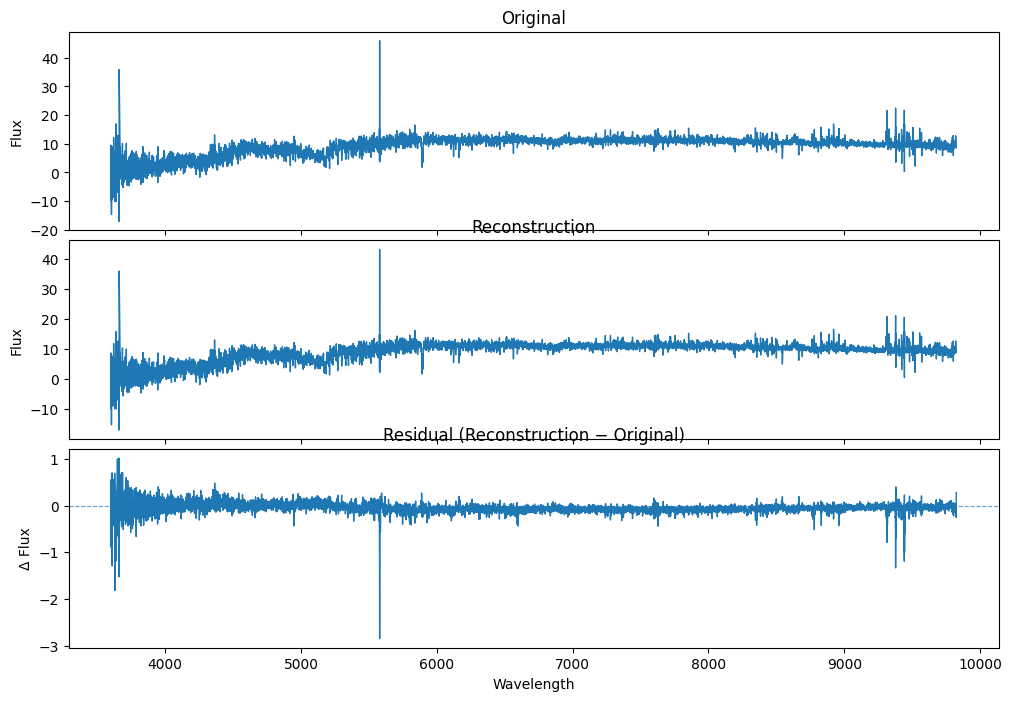

In [99]:
row = train_df.row(random.randint(0, train_df.height - 1), named=True)
print(row)
out = run_one_object_ae_flux_only(row, model, device="cuda")

if out is not None:
    import matplotlib.pyplot as plt
    import numpy as np

    w = out["wave"]
    f = out["flux"]
    f_hat = out["flux_hat"]
    m = out["mask"]

    resid = f_hat - f

    fig, axes = plt.subplots(
        nrows=3,
        ncols=1,
        figsize=(12, 8),
        sharex=True,
        gridspec_kw={"hspace": 0.05},
    )

    # -------------------
    # Original
    # -------------------
    axes[0].plot(w[m], f[m], lw=1)
    axes[0].set_ylabel("Flux")
    axes[0].set_title("Original")

    # -------------------
    # Reconstruction
    # -------------------
    axes[1].plot(w[m], f_hat[m], lw=1)
    axes[1].set_ylabel("Flux")
    axes[1].set_title("Reconstruction")

    # -------------------
    # Residual
    # -------------------
    axes[2].plot(w[m], resid[m], lw=1)
    axes[2].axhline(0.0, ls="--", lw=0.8, alpha=0.7)
    axes[2].set_ylabel("Δ Flux")
    axes[2].set_xlabel("Wavelength")
    axes[2].set_title("Residual (Reconstruction − Original)")

    plt.tight_layout()
    plt.show()

In [100]:
import polars as pl
from tqdm import tqdm

import numpy as np
import torch

@torch.no_grad()
def encode_one_row_flux_only(row: dict, model, device="cuda"):
    """
    row: dict-like with DESI arrays (from polars row(named=True))
    returns:
      z_np: np.ndarray [latent_dim, T]  (float32)
      or None if empty spectrum
    """
    w, f, iv, mask = stitch_desi_arms(
        row.get("desi_wave_b"), row.get("desi_flux_b"), row.get("desi_ivar_b"),
        row.get("desi_wave_r"), row.get("desi_flux_r"), row.get("desi_ivar_r"),
        row.get("desi_wave_z"), row.get("desi_flux_z"), row.get("desi_ivar_z"),
    )
    if f.size == 0:
        return None

    mask = mask.astype(bool)

    # SAME normalization as training
    stats = robust_flux_stats(f, mask)
    f_norm = normalize_flux(f, stats).astype(np.float32)

    # model expects [B,L,1]
    x = torch.from_numpy(f_norm[:, None]).unsqueeze(0).to(device)  # [1,L,1]
    z = model.encode(x)  # [1, latent_dim, T]

    return z.squeeze(0).detach().float().cpu().numpy()  # [latent_dim, T]

def encode_df_to_latents_polars(df: pl.DataFrame, model, device="cuda", id_col="id") -> pl.DataFrame:
    model.eval().to(device)

    ids_out = []
    latents_out = []

    # iter_rows(named=True) is the simplest & safest for list columns
    for row in tqdm(df.iter_rows(named=True), total=df.height, desc="Encoding"):
        obj_id = row[id_col]
        z = encode_one_row_flux_only(row, model, device=device)
        if z is None:
            continue

        ids_out.append(obj_id)
        latents_out.append(z.reshape(-1).tolist())  # flatten latent_dim*T

    return pl.DataFrame(
        {
            id_col: ids_out,
            "latent": latents_out,  # List[float]
        }
    )

In [101]:
lat_df = encode_df_to_latents_polars(train_df, model, device="cuda", id_col="id")
print(lat_df)

Encoding:   0%|          | 166/162704 [00:00<10:13, 265.11it/s]

Encoding: 100%|██████████| 162704/162704 [09:19<00:00, 290.62it/s]


shape: (162_704, 2)
┌───────────────────┬─────────────────────────────────┐
│ id                ┆ latent                          │
│ ---               ┆ ---                             │
│ binary            ┆ list[f64]                       │
╞═══════════════════╪═════════════════════════════════╡
│ b"i06n01s040003U" ┆ [1.876337, -0.894627, … 0.0865… │
│ b"i06n01s040005K" ┆ [0.281962, 2.087185, … 0.32901… │
│ b"i06n01s040005U" ┆ [-2.487012, 1.023529, … -0.184… │
│ b"i06n01s040006C" ┆ [1.787815, 3.005459, … 0.41456… │
│ b"i06n01s040007A" ┆ [0.588818, -0.516254, … -0.309… │
│ …                 ┆ …                               │
│ b"i06s13s120110T" ┆ [4.63525, -0.418773, … -0.3331… │
│ b"i06s13s12011EW" ┆ [-0.091681, 0.366326, … 0.1041… │
│ b"i06s13s12011I3" ┆ [1.266137, -1.064715, … 0.4247… │
│ b"i06s13s12011U0" ┆ [0.804412, -0.127837, … 0.0907… │
│ b"i06s13s12011V1" ┆ [-0.117586, -2.601095, … 0.306… │
└───────────────────┴─────────────────────────────────┘


In [102]:
from __future__ import annotations
from typing import Optional, Tuple, Any

import numpy as np
import torch
from torch.utils.data import Dataset

class LatentsPolarsDataset(Dataset):
    """
    df columns:
      - id_col: object id
      - latent_col: list-like latent stored as:
          (a) flat:  [latent_dim*T]
          (b) nested: [latent_dim][T]
          (c) nested: [T][latent_dim]

    returns:
      x    : float32 [T, C]   (sequence length T, channels C=latent_dim)
      id   : python object (string/int)
    """
    def __init__(
        self,
        df,
        *,
        id_col: str = "id",
        latent_col: str = "latent",
        latent_dim: Optional[int] = 16,  # needed for flat case
        nested_layout: str = "auto",      # "auto" | "C_T" | "T_C"
    ):
        self.df = df
        self.id_col = id_col
        self.latent_col = latent_col
        self.latent_dim = latent_dim
        self.nested_layout = nested_layout

    def __len__(self) -> int:
        return self.df.height

    def _to_TC(self, latent: Any) -> np.ndarray:
        """
        Convert latent to ndarray [T, C].
        """
        arr = np.asarray(latent, dtype=np.float32)

        # --- flat case: [C*T]
        if arr.ndim == 1:
            if self.latent_dim is None:
                raise ValueError("latent_dim must be provided when latent is stored flat.")
            C = int(self.latent_dim)
            if arr.size % C != 0:
                raise ValueError(f"Flat latent length {arr.size} not divisible by latent_dim={C}.")
            T = arr.size // C
            return arr.reshape(C, T).T  # [T,C]

        # --- nested case
        if arr.ndim == 2:
            a0, a1 = arr.shape

            if self.nested_layout == "C_T":
                return arr.T  # [T,C]
            if self.nested_layout == "T_C":
                return arr    # [T,C]

            # auto: decide by latent_dim if available, else fallback heuristics
            if self.latent_dim is not None:
                C = int(self.latent_dim)
                if a0 == C:
                    return arr.T
                if a1 == C:
                    return arr

            # heuristic: treat smaller dimension as C if it looks like channels
            # (common: C=8/16/32/64)
            if a0 in (8, 16, 32, 64):
                return arr.T
            return arr

        raise ValueError(f"Unsupported latent array ndim={arr.ndim}")

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        row = self.df.row(idx, named=True)
        obj_id = row[self.id_col]
        latent = row[self.latent_col]

        x_tc = self._to_TC(latent)  # [T,C]

        if x_tc.size == 0:
            # keep tokenizer safe
            x_tc = np.zeros((1, int(self.latent_dim or 1)), dtype=np.float32)

        return torch.from_numpy(x_tc), obj_id
    
    
import math
import torch

def collate_latents_pad_to_patch_multiple(batch, patch_size: int, pad_value: float = 0.0):
    """
    batch: list of (x[T,C], id)
    returns:
      x_pad   : [B, Lpad, C] float32
      mask    : [B, Lpad]    bool   (True for real tokens)
      lengths : [B]          int64  (original T)
      ids     : list         (object ids)
    """
    xs, ids = zip(*batch)
    lengths = torch.tensor([x.shape[0] for x in xs], dtype=torch.long)
    Tmax = int(lengths.max().item())
    C = int(xs[0].shape[1])

    Lpad = int(math.ceil(Tmax / patch_size) * patch_size)
    B = len(xs)

    x_pad = torch.full((B, Lpad, C), float(pad_value), dtype=torch.float32)
    mask = torch.zeros((B, Lpad), dtype=torch.bool)

    for i, x in enumerate(xs):
        T = x.shape[0]
        x_pad[i, :T] = x
        mask[i, :T] = True

    return x_pad, mask, lengths, list(ids)

from torch.utils.data import DataLoader

# Example: your AE latent_dim was 16
LATENT_DIM = 16
P = 16  # patch_size for SpectralPatchRVQ

ds_lat = LatentsPolarsDataset(
    lat_df,
    id_col="id",
    latent_col="latent",
    latent_dim=LATENT_DIM,
    nested_layout="auto",  # works for flat or nested
)

loader_lat = DataLoader(
    ds_lat,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=lambda batch: collate_latents_pad_to_patch_multiple(batch, patch_size=P),
)

In [103]:
from astromodal.tokenizers.spectralrvq import SpectralPatchRVQ
from astromodal.tokenizers.rvq import ResidualVQ
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

P = 2
C = LATENT_DIM
D = P * C

rvq = ResidualVQ(dim=D, num_stages=3, codebook_size=1024, decay=0.99).to(device)
tok = SpectralPatchRVQ(rvq=rvq, patch_size=P, channels=C).to(device)

tok.train()
for epoch in range(20):
    stats = tok.train_epoch(loader_lat, device=device, update_ema=True)
    print(epoch, stats)

0 {'loss': 0.12302235884439723}
1 {'loss': 0.11120172519900241}
2 {'loss': 0.10889942919798265}
3 {'loss': 0.10817781845832108}
4 {'loss': 0.10782118214332596}
5 {'loss': 0.10762385136361483}
6 {'loss': 0.10748104562519316}
7 {'loss': 0.10734959822838631}
8 {'loss': 0.10726967961920762}
9 {'loss': 0.10720477604077082}
10 {'loss': 0.10713630148895324}
11 {'loss': 0.10709451040648138}
12 {'loss': 0.1070529623284067}
13 {'loss': 0.10702835844000107}
14 {'loss': 0.10700723175345908}
15 {'loss': 0.10697441478871188}
16 {'loss': 0.10695041944034239}
17 {'loss': 0.10693309971767255}
18 {'loss': 0.10691359502743544}
19 {'loss': 0.1069048159685338}


In [104]:
import numpy as np
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def run_full_chain_and_plot(
    row,
    ae_model,
    tok_model,
    device="cuda",
    *,
    plot=True,
    max_points=None,          # optionally downsample for faster plotting
):
    ae_model.eval().to(device)
    tok_model.eval().to(device)

    # -------------------------
    # 1) stitch
    # -------------------------
    w, f, iv, mask = stitch_desi_arms(
        row.get("desi_wave_b"), row.get("desi_flux_b"), row.get("desi_ivar_b"),
        row.get("desi_wave_r"), row.get("desi_flux_r"), row.get("desi_ivar_r"),
        row.get("desi_wave_z"), row.get("desi_flux_z"), row.get("desi_ivar_z"),
    )
    if f.size == 0:
        return None

    mask = mask.astype(bool)

    # optional plot downsample (keeps mask alignment)
    if max_points is not None and f.size > max_points:
        idx = np.linspace(0, f.size - 1, max_points).astype(int)
        w = w[idx]
        f = f[idx]
        mask = mask[idx]
        iv = iv[idx]

    # -------------------------
    # 2) normalize (same as training)
    # -------------------------
    stats = robust_flux_stats(f, mask)
    f_norm = normalize_flux(f, stats).astype(np.float32)

    x = torch.from_numpy(f_norm[:, None]).unsqueeze(0).to(device)  # [1,L,1]
    L = x.shape[1]

    # -------------------------
    # 3) AE encode/decode (normalized)
    # -------------------------
    z_ae = ae_model.encode(x)                                # [1, C_lat, T]
    xhat_ae_norm = ae_model.decode(z_ae, L_out=L)            # [1, L, 1]
    fhat_ae_norm = xhat_ae_norm[0, :, 0].detach().cpu().numpy()
    fhat_ae = denormalize_flux(fhat_ae_norm, stats)

    # latent sequence for tokenizer: [B, T, C_lat]
    z_seq = z_ae.transpose(1, 2).contiguous()               # [1, T, C_lat]
    T = z_seq.shape[1]
    C_lat = z_seq.shape[2]

    if hasattr(tok_model, "channels") and int(tok_model.channels) != int(C_lat):
        raise ValueError(
            f"Tokenizer channels={tok_model.channels} but AE latent_dim={C_lat}. "
            f"Instantiate tok with channels=latent_dim."
        )

    # -------------------------
    # 4) Tokenizer encode/decode in latent space
    # -------------------------
    enc_tok = tok_model.encode(z_seq, update_ema=False)
    codes = enc_tok["codes"]              # [1, T_tok, R]
    T_tok = int(enc_tok["T"])
    L_lat = int(enc_tok["L"])             # should equal T (latent length)

    zq_seq = tok_model.decode(codes, L=L_lat)     # [1, L_lat, C_lat]
    zq_seq = zq_seq[:, :T, :]                     # [1, T, C_lat] match AE z length

    # -------------------------
    # 5) Decode tokenizer-quantized latents back to flux (normalized->denorm)
    # -------------------------
    zq_ae = zq_seq.transpose(1, 2).contiguous()   # [1, C_lat, T]
    xhat_final_norm = ae_model.decode(zq_ae, L_out=L)  # [1, L, 1]
    fhat_final_norm = xhat_final_norm[0, :, 0].detach().cpu().numpy()
    fhat_final = denormalize_flux(fhat_final_norm, stats)

    # -------------------------
    # 6) residuals (flux units)
    # -------------------------
    resid_ae = fhat_ae - f
    resid_final = fhat_final - f
    resid_final_vs_ae = fhat_final - fhat_ae

    # -------------------------
    # 6b) residuals in sigma units (chi)
    # chi = (fhat - f) / sigma_noise = (fhat - f) * sqrt(ivar)
    # -------------------------
    chi_ae = np.full_like(f, np.nan, dtype=np.float64)
    chi_final = np.full_like(f, np.nan, dtype=np.float64)
    chi_final_vs_ae = np.full_like(f, np.nan, dtype=np.float64)

    good = mask & np.isfinite(iv) & (iv > 0)
    if np.any(good):
        s = np.sqrt(iv[good])
        chi_ae[good] = resid_ae[good] * s
        chi_final[good] = resid_final[good] * s
        chi_final_vs_ae[good] = resid_final_vs_ae[good] * s

    out = {
        "wave": w,
        "mask": mask,
        "ivar": iv,
        "flux": f,
        "flux_hat_ae": fhat_ae,
        "flux_hat_final": fhat_final,
        "resid_ae_minus_orig": resid_ae,
        "resid_final_minus_orig": resid_final,
        "resid_final_minus_ae": resid_final_vs_ae,
        "chi_ae_minus_orig": chi_ae,
        "chi_final_minus_orig": chi_final,
        "chi_final_minus_ae": chi_final_vs_ae,
        "latent_ae_ct": z_ae[0].detach().cpu().numpy(),      # [C_lat, T]
        "latent_tok_tc": zq_seq[0].detach().cpu().numpy(),   # [T, C_lat]
        "codes": codes.detach().cpu(),                       # [1, T_tok, R]
        "mu": stats.mu,
        "sigma": stats.sigma,                                # normalization sigma (NOT noise sigma)
    }

    # -------------------------
    # 7) plotting
    # -------------------------
    if plot:
        m = mask

        fig, axes = plt.subplots(
            5, 1, figsize=(12, 12), sharex=True,
            gridspec_kw={"hspace": 0.50}
        )

        axes[0].plot(w[m], f[m], lw=1)
        axes[0].set_ylabel("Flux")
        axes[0].set_title("Original (stitched)")

        axes[1].plot(w[m], fhat_ae[m], lw=1)
        axes[1].set_ylabel("Flux")
        axes[1].set_title("AE reconstruction")

        axes[2].plot(w[m], fhat_final[m], lw=1)
        axes[2].set_ylabel("Flux")
        axes[2].set_title("Final reconstruction (AE ∘ Tok ∘ AE)")

        axes[3].plot(w[m], resid_ae[m], lw=1, label="AE − Orig", alpha=0.5)
        axes[3].plot(w[m], resid_final_vs_ae[m], lw=1, label="Final − AE", alpha=0.5)
        axes[3].plot(w[m], resid_final[m], lw=1, label="Final − Orig", alpha=0.5)
        axes[3].axhline(0.0, ls="--", lw=0.8, alpha=0.7)
        axes[3].set_ylabel("Δ Flux")
        axes[3].set_title("Residuals (flux units)")
        axes[3].legend()

        # sigma-units residuals (chi)
        axes[4].plot(w[good], chi_ae[good], lw=1, label="(AE − Orig) / σ", alpha=0.6)
        axes[4].plot(w[good], chi_final_vs_ae[good], lw=1, label="(Final − AE) / σ", alpha=0.6)
        axes[4].plot(w[good], chi_final[good], lw=1, label="(Final − Orig) / σ", alpha=0.6)
        axes[4].axhline(0.0, ls="--", lw=0.8, alpha=0.7)
        axes[4].axhline(+1.0, ls=":", lw=0.8, alpha=0.5)
        axes[4].axhline(-1.0, ls=":", lw=0.8, alpha=0.5)
        axes[4].axhline(+3.0, ls=":", lw=0.8, alpha=0.5)
        axes[4].axhline(-3.0, ls=":", lw=0.8, alpha=0.5)
        axes[4].set_ylabel("Residual (σ units)")
        axes[4].set_xlabel("Wavelength")
        axes[4].set_title("Residuals in sigma units (χ), using DESI ivar")
        axes[4].legend()

        plt.tight_layout()
        plt.show()

    return out


/tmp/ipykernel_1830877/952695244.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


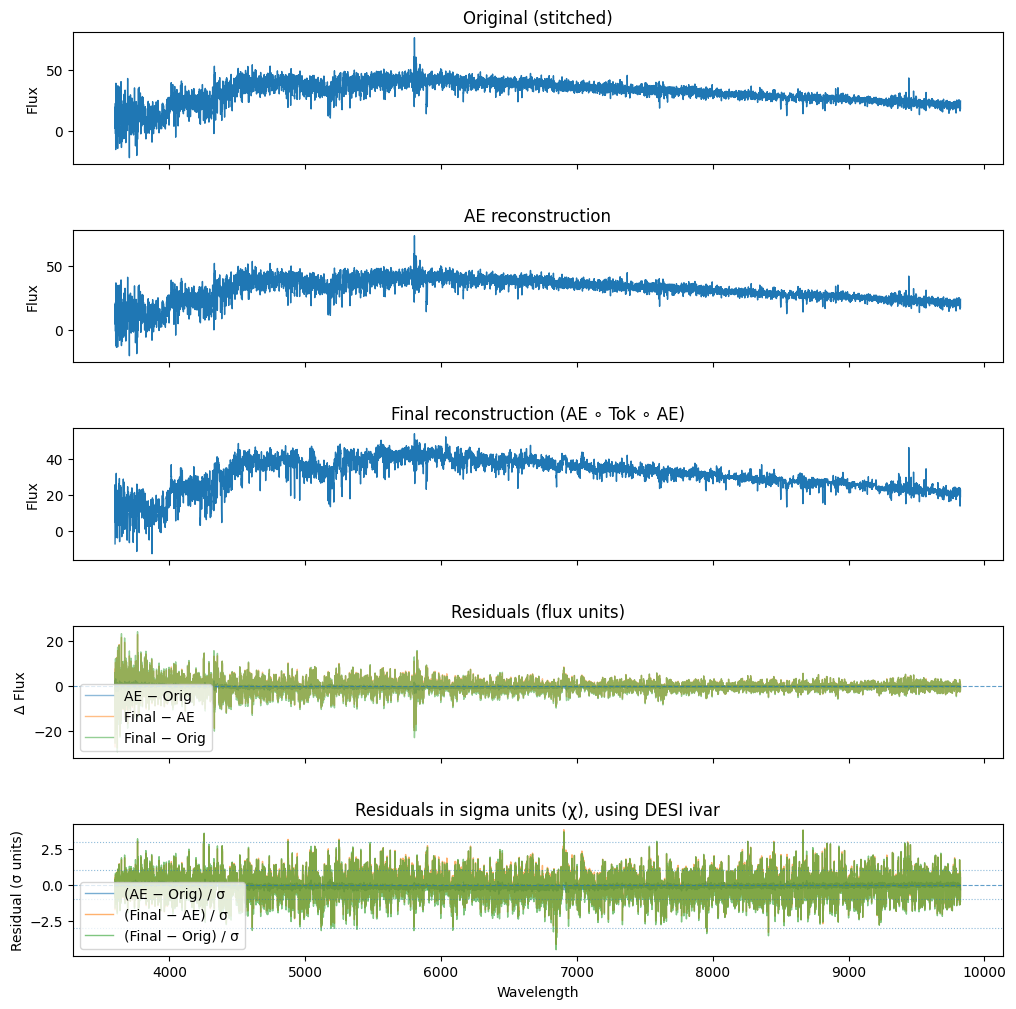

In [108]:
row = train_df.row(random.randint(0, train_df.height - 1), named=True)

out = run_full_chain_and_plot(
    row=row,
    ae_model=model,
    tok_model=tok,     # trained RVQ tokenizer over AE latents
    device="cuda",
    plot=True,
)

In [113]:
tok.save(Path(config['models_folder']) / "spectral_patch_rvq_desi.pth")

[info] - Saved SpectralPatchRVQ to /home/schwarz/projetoFM/outputs/spectral_patch_rvq_desi.pth
